# Colab Setting

In [2]:
import os
from google.colab import drive
# mount Google drive
drive.mount('/content/drive')


# by default everything gets executed and saved in 'Berkeley Capstone (Students)'
# notebook_path = '/content/drive/MyDrive/Berkeley Capstone (Students)/Code' # WK
notebook_path = '/content/drive/MyDrive/Capstone/Berkeley Capstone (Students)/Code/InsDetek3.0_LSTM' # GQ
os.chdir(notebook_path)

!echo -e "\nCurrent directory:"
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Current directory:
/content/drive/.shortcut-targets-by-id/1yBERxWlYaZqd2aPZEzBr21t8G6McvwZA/Berkeley Capstone (Students)/Code/InsDetek3.0_LSTM


In [3]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import seaborn as sns

# Read Data

In [ ]:
# df = pd.read_csv('week_norm_all_withweek.csv') # norm on whole dataset
df = pd.read_csv('week_norm_all.csv')

In [ ]:
df.shape

(67166, 446)

# Model

## Step 1 Data Processing

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence
import torch.nn.functional as F

from collections import defaultdict

### Dataloader

In [ ]:

class MyData(Dataset): 
        def __init__(self, x, y):
            self.feature = x
            self.label = y
        def __len__(self): 
            return len(self.feature)
        def __getitem__(self, idx):
            return (self.feature[idx], self.label[idx])
            
# sequences by user: df to tensor
def df_to_tensor(df, batch_size, all_label, print_summary = False, shuffle = False):
    """
    Args:
        df (DataFrame): sequences(both feature and label) in a DataFrame.
        all_label (bool): output will be the labels of the whole sequence if True,
                          or the label of the last datapoint in the sequence otherwise.
        print_summary (bool, optional): print the size of output.
        shuffle (bool): aisheishei
    """

    def collate_fn(feature_label): 

        # 第一维是batchsize，所以直接enumerate循环会循环20次
        # feature_label - List:[batchsize个Tuple:(2个Tensor:[maxlen, dimension])] batchsize*2*maxlen*dimension

        features, labels = [], []
        # labels = torch.zeros(len(feature_label), len(feature_label[1][0]))
        for unit in feature_label:
            features.append(unit[0])
            labels.append(unit[1])

        # pad features
        seqs_len = [sequence.size(0) for sequence in features]
        padded_f = pad_sequence(features, batch_first=True, padding_value=0) # 所有sequence补零对齐长度，然后摞在一起
        

        # pad features labels
        seqs_len = [sequence.size(0) for sequence in labels]
        padded_l = pad_sequence(labels, batch_first=True, padding_value=0) # 所有sequence补零对齐长度，然后摞在一起

        # masks
        masks = [torch.ones(seq_len) for seq_len in seqs_len]
        padded_m = pad_sequence(masks, batch_first=True, padding_value=0)

        return (padded_f, padded_l, padded_m)

    # dic of sequences in df format
    fea_df_dic = defaultdict(pd.DataFrame) # feature seq
    label_df = defaultdict(pd.DataFrame)# label seq
    for user in df.user.unique():
        fea_df_dic[user] = df[df.user == user].iloc[:, 1:-1]
        if all_label:
            # labels are the insider status of all activities in the sequence. [batchsize, maxlength (, 1)]
            label_df[user] = df[df.user == user].iloc[:, -1]
        else:
            # label is the insider status of the last activity in the sequence. [batchsize (, 1, 1)]
            label_df[user] = df[df.user == user].iloc[:, -1].iloc[[-1]]

    # list of features in tensor format (Need to be float32!)
    features = []
    for user, df_i in fea_df_dic.items():
        input_sub = torch.tensor(df_i.values).to(torch.float32)
        features.append(input_sub)
    # list of labels in tensor format (Need to be long!)
    labels = []
    for user, df_i in label_df.items():
        input_sub = torch.tensor(df_i.values).to(torch.long)
        labels.append(input_sub)

    # sequences tensors tuple to Dataset/DataLoader object
    data = MyData(features, labels)
    data_loader = DataLoader(data, batch_size, shuffle=shuffle, collate_fn=collate_fn) 

    if print_summary:
        print("==== DataFrame to DataLoader ====")
        print("Input DataFrame: {}".format(df.shape))
        print("   => {0} sequences ({0} users)".format(len(features)))
        print("       features in size of [(max) length, dimension] = {}".format(features[0].shape))
        print("       labels in size of [(max) length, dimension] = {}".format(labels[0].shape))
        print("   => output DataLoader: {} batches".format(len(data_loader)), "(batchsize = {})".format(batch_size))
        print("       features in size of [batchsize, (max) length, dimension] = {}".format(iter(data_loader).next()[0].shape))
        print("       labels in size of [batchsize, (max) length] = {}".format(iter(data_loader).next()[1].shape))
        print("       masks in size of [batchsize, (max) length] = {}".format(iter(data_loader).next()[2].shape))
    return data_loader

In [ ]:
# # data_loader = df_to_tensor(df, batch_size, all_label = False, print_summary = True)
# data_loader = df_to_tensor(df, batch_size = 50, all_label = True, print_summary = True, shuffle = True)

In [ ]:
# for fea, lab, mask in data_loader:
#     # print(fea,fea.shape)
#     print(fea.shape, lab.shape, mask.shape)
#     break

## Step 2 LSTM structure

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, input_size, hidden_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)       
        self.hidden2tag = nn.Linear(hidden_size, tagset_size)

    def forward(self, input):
        self.input_seq = input
        self.lstm_out, (self.hidden, self.cell) = self.lstm(self.input_seq)
        tag_space = self.hidden2tag(self.lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores


In [ ]:
def accuracy(predictions, targets):
    """Return the accuracy percentage of a list of predictions.
    
    predictions has only the predicted tags
    targets has tuples of (word, tag)
    """
    assert len(predictions) == len(targets)
    n_correct = 0
    for predicted_tag, (word, gold_tag) in zip(predictions, targets):
        if predicted_tag == gold_tag:
            n_correct += 1

    return n_correct / len(targets) * 100.0

### hyperparam & model

In [ ]:
batch_size = 50
# data_loader = df_to_tensor(df, batch_size, all_label = False, print_summary = True)
data_loader = df_to_tensor(df, batch_size, all_label = True, print_summary = True, shuffle = True)

==== DataFrame to DataLoader ====
Input DataFrame: (67166, 446)
   => 1000 sequences (1000 users)
       features in size of [(max) length, dimension] = torch.Size([72, 444])
       labels in size of [(max) length, dimension] = torch.Size([72])
   => output DataLoader: 20 batches (batchsize = 50)
       features in size of [batchsize, (max) length, dimension] = torch.Size([50, 72, 444])
       labels in size of [batchsize, (max) length] = torch.Size([50, 72])
       masks in size of [batchsize, (max) length] = torch.Size([50, 72])


In [ ]:
# batch_demo = pad_packed_sequence(iter(data_loader).next()[0], batch_first = True)[0]
batch_demo = iter(data_loader).next()[0]
batch_shape = batch_demo.shape
batch_shape

torch.Size([50, 72, 444])

In [ ]:
### PARAMETERS ###
batch_size = batch_shape[0] 
# seq_len = batch_shape[1] 
input_size = batch_shape[2] # dimension of features
hidden_size = 16      # 
num_layers = 1 # 
num_class = 2 # 0/1

In [ ]:
model = LSTMTagger(input_size, hidden_size, num_class)
loss_function = nn.NLLLoss(reduction = 'none')
# loss_function = nn.NLLLoss()
# loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
params_name = list(model.state_dict().keys())
params_name

['lstm.weight_ih_l0',
 'lstm.weight_hh_l0',
 'lstm.bias_ih_l0',
 'lstm.bias_hh_l0',
 'hidden2tag.weight',
 'hidden2tag.bias']

In [ ]:
for param, val in model.state_dict().items():
    print(param, val.shape)

lstm.weight_ih_l0 torch.Size([64, 444])
lstm.weight_hh_l0 torch.Size([64, 16])
lstm.bias_ih_l0 torch.Size([64])
lstm.bias_hh_l0 torch.Size([64])
hidden2tag.weight torch.Size([2, 16])
hidden2tag.bias torch.Size([2])


### before train

In [ ]:
before = model.state_dict()
# before

In [ ]:
### See what the scores are before training ###
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
print_shape = True
with torch.no_grad():
    for feature_seqs, label_seqs, mask_seqs in tqdm(data_loader):
        if print_shape:
            print('features:', feature_seqs.shape, '\nlabel:', label_seqs.shape, '\nmask:', mask_seqs.shape)
            print_shape = False
        inputs = feature_seqs
        tag_scores = model(inputs[[0]])
        # print(tag_scores)

  0%|          | 0/20 [00:00<?, ?it/s]

features: torch.Size([50, 72, 444]) 
label: torch.Size([50, 72]) 
mask: torch.Size([50, 72])


In [ ]:
# lstm input: one user out of the batchsize users
# pd.DataFrame(np.array(model.input_seq[0])) # [1,72,667]
model.input_seq.shape

torch.Size([1, 72, 444])

In [ ]:
a = torch.tensor([[[1]]])
a.shape

torch.Size([1, 1, 1])

## Step 3 Train

In [ ]:
# epoch_bar = tqdm(range(epoch), leave = True)
epoch_bar = tqdm(range(100), leave = True)
loss_list = []
gradient_list = []
for epoch in epoch_bar:  
    batch_bar = tqdm(data_loader, leave = True)
    for batch_i, (feature_seqs, label_seqs, mask_seqs) in enumerate(batch_bar): # get feature sequenceS, label sequenceS and mask sequenceS

        # == Step 1. clear gradient ==
        model.zero_grad()

        # == Step 2. Run forward pass ==
        predict_seqs = model(feature_seqs)

        # == Step 3.1 Compute the loss ==
        seq_len = feature_seqs.shape[1] 
        predict_seqs = predict_seqs.reshape([batch_size,num_class,seq_len])
        # [20,72,2]→[20,2,72] Because the input of NLLLoss is in (C,N_class, d1, d2, ...)
        # print('predict_seqs.shape', predict_seqs.shape)
        # print('label_seqs.shape',label_seqs.shape)

        loss = loss_function(predict_seqs, label_seqs) # loss.shape = [batchsize, seq_len] = [20,72]
        loss = torch.mul(loss, mask_seqs).reshape(-1).mean()

        # 首先是不是要scores和label size相同，都onehot或者都不
        # 其次，如果我补零补的是label里没有出现大的-1， 那tagset_size是不是就要从2变成3？是不是要多一类出来？


        # == Step 3.2 Compute the gradients ==
        loss.backward()
        # == Step 3.3 Update the parameters ==

        # [0:'lstm.weight_ih_l0', 1:'lstm.weight_hh_l0', 2:'lstm.bias_ih_l0', 3:'lstm.bias_hh_l0', 4:'hidden2tag.weight', 5:'hidden2tag.bias']
        p_i = 0
        # print('batch', batch_i, params_name[p_i], optimizer.param_groups[0]['params'][p_i].shape, optimizer.param_groups[0]['params'][p_i].grad)
        gradient_list.append(optimizer.param_groups[0]['params'][p_i].grad.numpy().tolist()) # need to add .numpy().tolist(), otherwise the grad value is changable, may saved the address
        
        para_before = model.state_dict()['lstm.weight_ih_l0']
        optimizer.step()
        if not model.state_dict()['lstm.weight_ih_l0'].equal(para_before):
            print('param changed')

        batch_bar.set_description('batch: %i' % batch_i)
        batch_bar.set_postfix(loss=format(loss,'.3f'))
    loss_list.append(loss)
    epoch_bar.set_description('Epoch: %i' % epoch)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/4 [00:01<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

# Plots

In [ ]:
# # to change default colormap
# plt.rcParams["image.cmap"] = "Set1"
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1.colors)

In [ ]:
info =  '==== model info ====\n'\
        + 'batchsize=' + str(batch_size)\
        + '\n' + 'optim=' + optimizer.__class__.__name__\
        + '(lr={:g})'.format(optimizer.param_groups[0]['lr'])
print(info)

==== model info ====
batchsize=50
optim=Adam(lr=0.001)


## Loss

(0.0, 5.0)

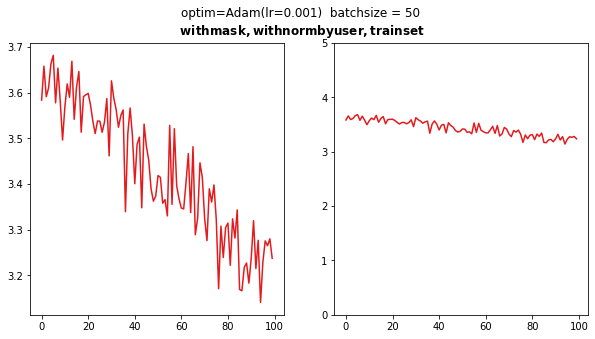

In [ ]:
losslist = []
for i in loss_list:
    losslist.append(float(i.detach().numpy()))
note = '\n $\mathbf{with mask, with norm by user, train set}$'
plt.figure(figsize = (10,5))
plt.suptitle(info.split('\n')[-1]+'  batchsize = {:d}'.format(batch_size)+note)
plt.subplot(1,2,1)
plt.plot(losslist)
plt.subplot(1,2,2)
plt.plot(losslist)
plt.ylim(0,5)

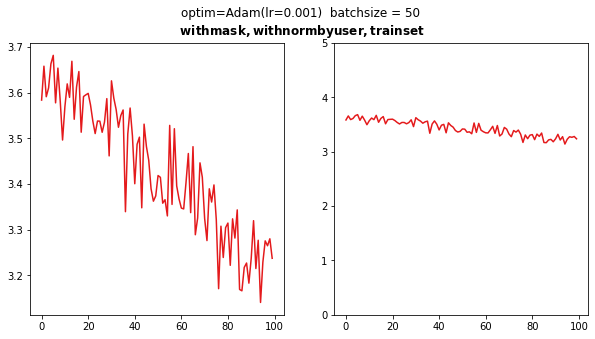

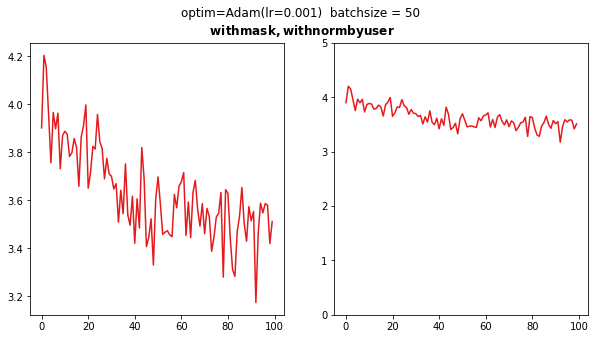

# Predict

In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, recall_score, precision_recall_curve, classification_report
import matplotlib.pyplot as plt

all_tags = {0: 0, 1: 1}
pre_batch_size = 1 ###
class Predictor():
    def __init__(self, model, raw_data):
              self.model = model
              self.raw_data = raw_data
    
    def predictor(self):
        """Return a list of part-of-speech tags as strings, one for each word.

        raw_data - a list of (word, tag) pairs.
        """

        with torch.no_grad(): # turns off automatic differentiation, which isn't required but helps save memory

            model.eval()
            loader = df_to_tensor(self.raw_data, batch_size = pre_batch_size, all_label = True, print_summary = False)

            predictions = []
            for batch in loader:
                feature_seqs, label_seqs, mask_seqs = batch

                seq_len = feature_seqs.shape[1]
                logits = self.model(feature_seqs) 
                output_distribution = logits.reshape(pre_batch_size*seq_len, num_class).tolist()
                index = int(mask_seqs.sum())

                pred = pd.DataFrame(output_distribution[:index]).idxmax(axis=1).tolist()
                predictions = predictions + pred

            model.train()
            return predictions

    def get_metrics(self):
        y_pred = self.predictor()
        yBin = self.raw_data['insider']
        report = classification_report(yBin, y_pred)
        print(report)

        # return report['True']

    # Compute ROC curve and ROC area for each class
    def acu_curve(self, y, prob):
        
        fpr, tpr, threshold = roc_curve(y, prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, 
                tpr, 
                color = 'darkorange',
                lw = 2, 
                label = 'ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
        plt.xlim([0.0, 1.00])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc = "lower right")
        plt.show()

    def pr_curve(self, y, prob):

        #calculate precision and recall
        precision, recall, thresholds = precision_recall_curve(y, prob)

        #create precision recall curve
        plt.figure(figsize=(10, 10))
        plt.plot(recall, precision, color='purple')

        #add axis labels to plot
        plt.title('Precision-Recall Curve')
        plt.ylabel('Precision')
        plt.xlabel('Recall')

        #display plot
        plt.show()

In [ ]:
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      9522
           1       0.03      0.31      0.05       242

    accuracy                           0.71      9764
   macro avg       0.50      0.52      0.44      9764
weighted avg       0.95      0.71      0.81      9764



# logs

### x_train seq_len变长

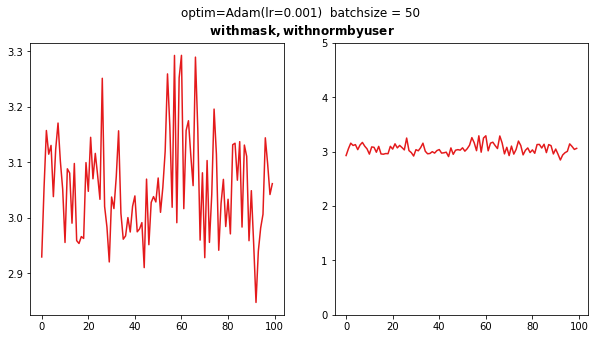

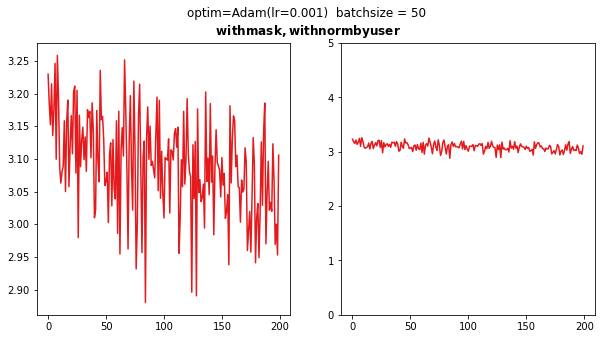

## NLLLoss, Adam, with mask, with norm by user

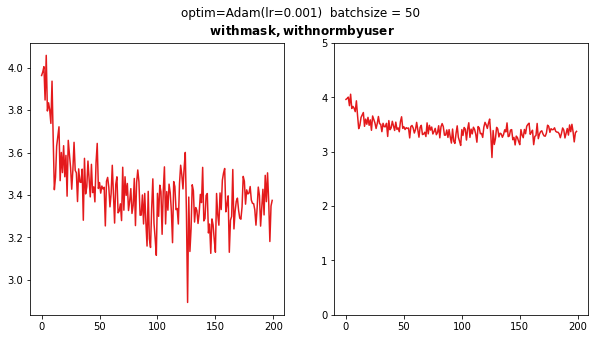

## NLLLoss, Adam, with mask, with norm

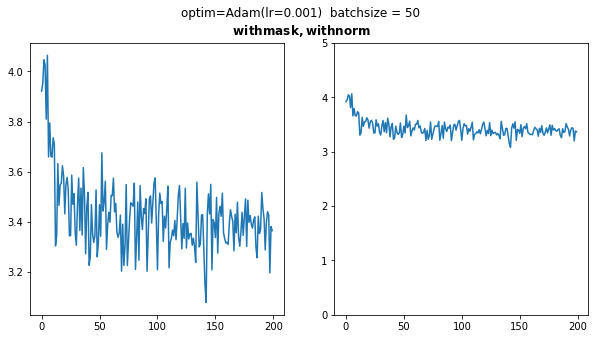

## NLLLoss, Adam, with mask

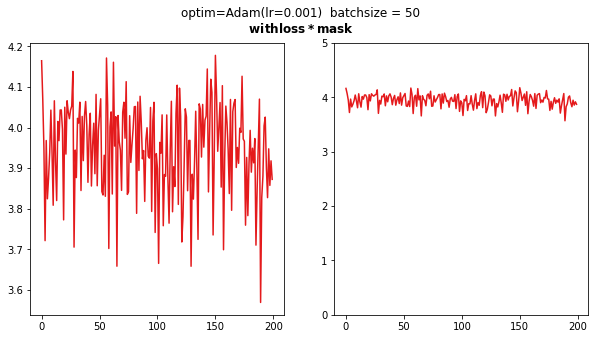

## NLLLoss, SGD, with mask

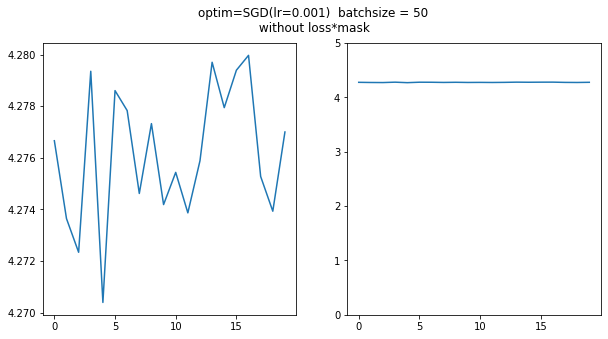
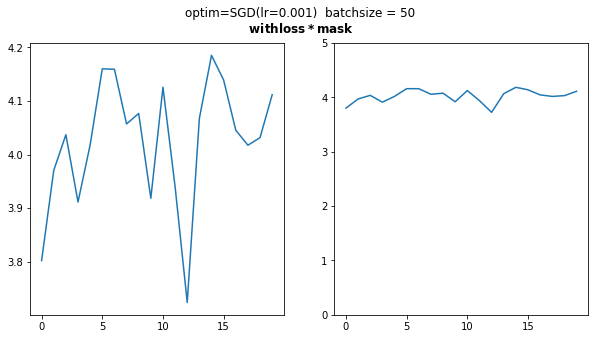
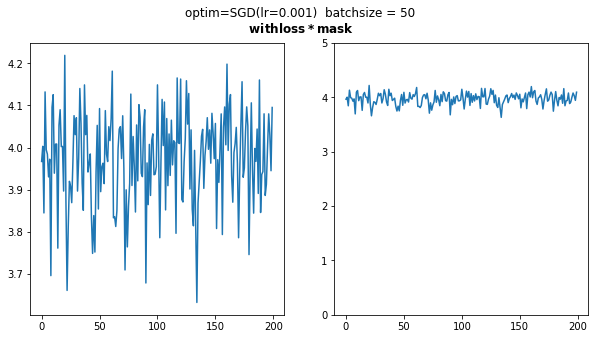

## BCELoss, Adam, with mask

## Gradients

In [ ]:
len(gradient_list)

4000

In [ ]:
npgrad = np.array(gradient_list)


In [ ]:
del gradient_list

NameError: ignored

In [ ]:
print(npgrad.shape)
print(npgrad[:,:,0].shape)

(4000, 64, 655)
(4000, 64)


In [ ]:
s=[]
ii=[]
jj=[]
for i in range(64):
  for j in range(655):
    if(npgrad[:,i,j].sum() != 0):
      s.append(npgrad[:,i,j])
      ii.append(i)
      jj.append(j)

In [ ]:
s[0].shape

(4000,)

Text(0.5, 1.0, 'parameters in lstm.weight_ih_l0 that changed')

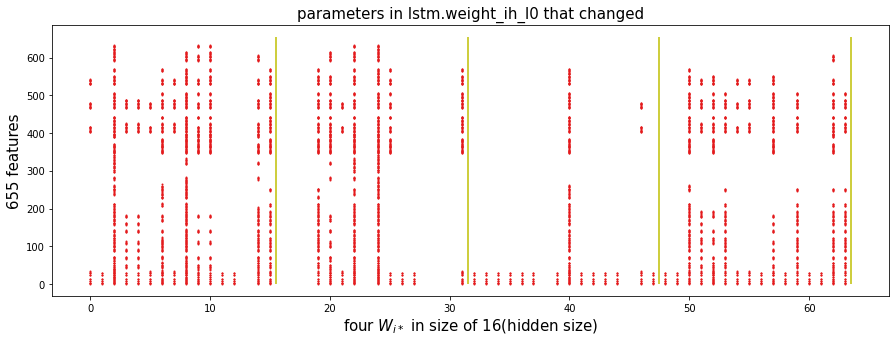

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(ii,jj,s=1)
plt.vlines([15.5,31.5,47.5,63.5],0,655, color='y')
plt.xlabel('four $W_{i*}$ in size of 16(hidden size)', fontsize=15)
plt.ylabel('655 features', fontsize=15)
plt.title('parameters in lstm.weight_ih_l0 that changed', fontsize=15)

In [ ]:

npgrad = np.array(gradient_list)
npgrad.reshape([40,32])

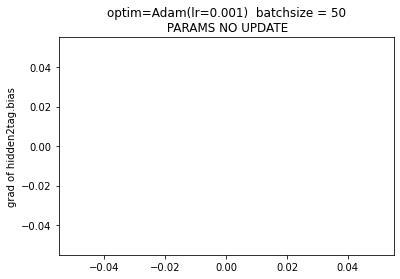

In [ ]:
plt.plot(gradient_list[:])
plt.ylabel('grad of hidden2tag.bias')
# plt.title('SGD lr=0.0001 PARAMS $\mathbf{UPDATED}$');
plt.title(info.split('\n')[-1]+'  batchsize = {:d}'.format(batch_size)+'\n PARAMS NO UPDATE');
# plt.ylim(-7e-08,9e-08)

### hidden2tag.bias NLL,SGD,no mask

<font size=5><center>__Gradients - hidden2tag.bias__</center></font>

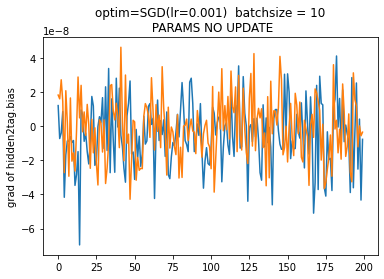
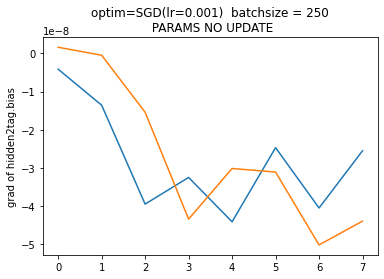
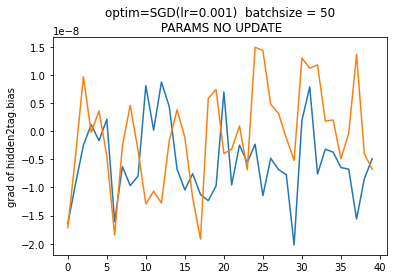
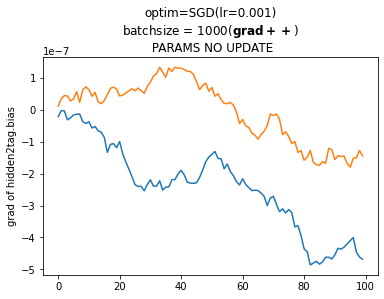
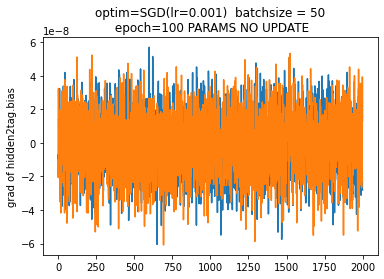

In [ ]:
optimizer.param_groups[0]['params'][-1].grad

tensor([-1.5832e-08, -2.3749e-08])

In [ ]:
after = model.state_dict()
after

In [ ]:
for k in before.keys():
    print(before[k].equal(after[k]))
#  WHAT THE HELL??????????????????????????????????????????????????????????????????????我训练了个寂寞啊？？？？？？？？？？？？？？？？
#  还有 model输出应该是一个值不是72个值啊，LSTM层的输出到底是什么维度的，输出一个还是72个。不是让我label改成all_label=False了嘛，为什么又开始72了。
# target_size=1？？？ 
# The targets shouldn't be one-hot, it's just numbers. so targets in 20,1 while target_scores in 20,2. WTH with the loss function?????

True
True
True
True
True
True


In [ ]:

# See what the scores are after training
with torch.no_grad():
    # inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs[[0]])

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

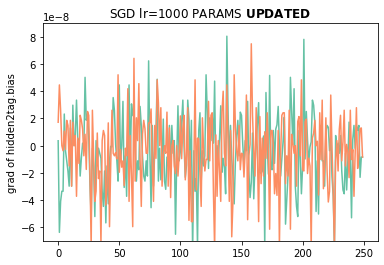

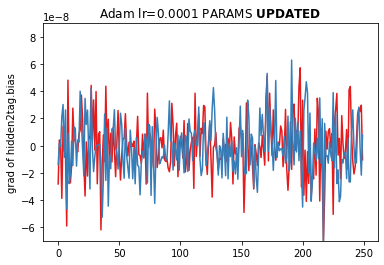
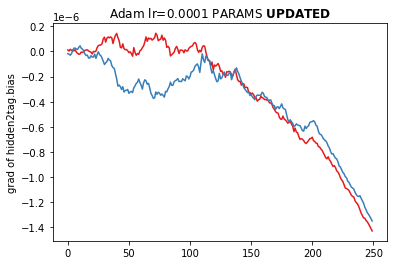

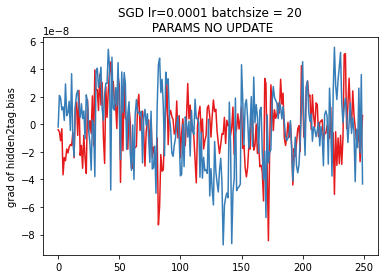

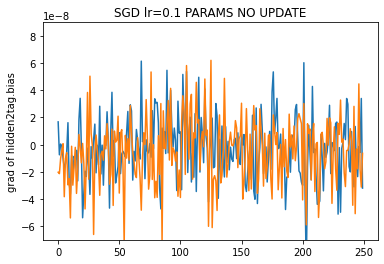
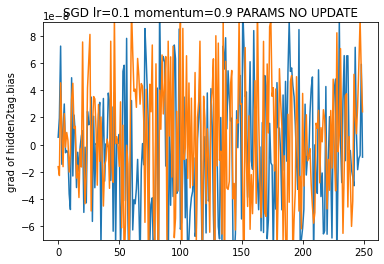
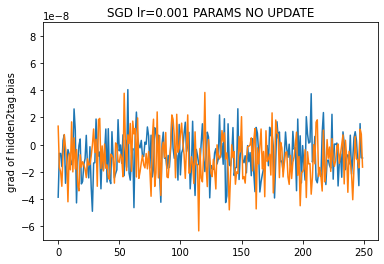
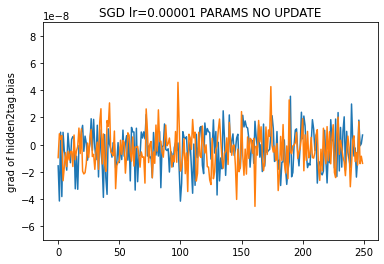

# Drafts

In [4]:
%%writefile dataloader_.py

import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence
from collections import defaultdict
import pandas as pd

class MyData(Dataset): 
        def __init__(self, x, y):
            self.feature = x
            self.label = y
        def __len__(self): 
            return len(self.feature)
        def __getitem__(self, idx):
            return (self.feature[idx], self.label[idx])
            
# sequences by user: df to tensor
def df_to_tensor(df, batch_size, all_label, print_summary = False, shuffle = False):
    """
    Args:
        df (DataFrame): sequences(both feature and label) in a DataFrame.
        all_label (bool): output will be the labels of the whole sequence if True,
                          or the label of the last datapoint in the sequence otherwise.
        print_summary (bool, optional): print the size of output.
        shuffle (bool): aisheishei
    """

    def collate_fn(feature_label): 

        # 第一维是batchsize，所以直接enumerate循环会循环20次
        # feature_label - List:[batchsize个Tuple:(2个Tensor:[maxlen, dimension])] batchsize*2*maxlen*dimension

        features, labels = [], []
        # labels = torch.zeros(len(feature_label), len(feature_label[1][0]))
        for unit in feature_label:
            features.append(unit[0])
            labels.append(unit[1])

        # pad features
        seqs_len = [sequence.size(0) for sequence in features]
        padded_f = pad_sequence(features, batch_first=True, padding_value=0) # 所有sequence补零对齐长度，然后摞在一起
        

        # pad features labels
        seqs_len = [sequence.size(0) for sequence in labels]
        padded_l = pad_sequence(labels, batch_first=True, padding_value=0) # 所有sequence补零对齐长度，然后摞在一起

        # masks
        masks = [torch.ones(seq_len) for seq_len in seqs_len]
        padded_m = pad_sequence(masks, batch_first=True, padding_value=0)

        return (padded_f, padded_l, padded_m)
    from collections import defaultdict
    # dic of sequences in df format
    fea_df_dic = defaultdict(pd.DataFrame) # feature seq
    label_df = defaultdict(pd.DataFrame)# label seq
    for user in df.user.unique():
        fea_df_dic[user] = df[df.user == user].iloc[:, 1:-1]
        if all_label:
            # labels are the insider status of all activities in the sequence. [batchsize, maxlength (, 1)]
            label_df[user] = df[df.user == user].iloc[:, -1]
        else:
            # label is the insider status of the last activity in the sequence. [batchsize (, 1, 1)]
            label_df[user] = df[df.user == user].iloc[:, -1].iloc[[-1]]

    # list of features in tensor format (Need to be float32!)
    features = []
    for user, df_i in fea_df_dic.items():
        input_sub = torch.tensor(df_i.values).to(torch.float32)
        features.append(input_sub)
    # list of labels in tensor format (Need to be long!)
    labels = []
    for user, df_i in label_df.items():
        input_sub = torch.tensor(df_i.values).to(torch.long)
        labels.append(input_sub)

    # sequences tensors tuple to Dataset/DataLoader object
    data = MyData(features, labels)
    data_loader = DataLoader(data, batch_size, shuffle=shuffle, collate_fn=collate_fn) 

    if print_summary:
        print("==== DataFrame to DataLoader ====")
        print("Input DataFrame: {}".format(df.shape))
        print("   => {0} sequences ({0} users)".format(len(features)))
        print("       features in size of [(max) length, dimension] = {}".format(features[0].shape))
        print("       labels in size of [(max) length, dimension] = {}".format(labels[0].shape))
        print("   => output DataLoader: {} batches".format(len(data_loader)), "(batchsize = {})".format(batch_size))
        print("       features in size of [batchsize, (max) length, dimension] = {}".format(iter(data_loader).next()[0].shape))
        print("       labels in size of [batchsize, (max) length] = {}".format(iter(data_loader).next()[1].shape))
        print("       masks in size of [batchsize, (max) length] = {}".format(iter(data_loader).next()[2].shape))
    return data_loader

Overwriting dataloader_.py
